# Learn AI Today: 03 - Potato Classifier using Convolutional Neural Networks 🥔🥔🥔

**What you will learn in this story:**

* Potatoes Are Not All the Same
* Using Kaggle Datasets
* How Convolutional Neural Networks Work
* Using fastai2 to Make Your Life Easier

**If you want to receive updates consider joining my mailing list at [learn-ai-today.com](http://learn-ai-today.com)**

## Note: The full description of the code and steps is available on Medium at [this link](https://towardsdatascience.com/learn-ai-today-03-potato-classification-using-convolutional-neural-networks-4481222f2806).

In [1]:
# Install fastai2 (note that soon fastai2 will be officially released as fastai)
!pip install fastai2

     |████████████████████████████████| 176 kB 571 kB/s 
     |████████████████████████████████| 748.8 MB 10 kB/s 
     |████████████████████████████████| 5.9 MB 26.3 MB/s 
ERROR: kornia 0.3.1 has requirement torch==1.5.0, but you'll have torch 1.6.0 which is incompatible.
ERROR: allennlp 1.0.0 has requirement torch<1.6.0,>=1.5.0, but you'll have torch 1.6.0 which is incompatible.
  Attempting uninstall: fastprogress
    Found existing installation: fastprogress 0.2.3
    Uninstalling fastprogress-0.2.3:
      Successfully uninstalled fastprogress-0.2.3
  Attempting uninstall: torch
    Found existing installation: torch 1.5.0
    Uninstalling torch-1.5.0:
      Successfully uninstalled torch-1.5.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.6.0a0+35d732a
    Uninstalling torchvision-0.6.0a0+35d732a:
      Successfully uninstalled torchvision-0.6.0a0+35d732a
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade p

In [2]:
from fastai2.vision.all import *

In [3]:
path = Path('/kaggle/input/fruits/fruits-360/')
train_fld = 'Training'

In [4]:
train_files = [o.ls() for o in (path/train_fld).ls() if 'Potato' in o.name]
train_files = [l for o in train_files for l in o]
len(train_files)

1803

In [5]:
train_df = pd.DataFrame({'file': train_files, 'id': [o.parent.name for o in train_files]})
train_df.head()

,file,id
0,/kaggle/input/fruits/fruits-360/Training/Potato Red Washed/15_100.jpg,Potato Red Washed
1,/kaggle/input/fruits/fruits-360/Training/Potato Red Washed/r_165_100.jpg,Potato Red Washed
2,/kaggle/input/fruits/fruits-360/Training/Potato Red Washed/11_100.jpg,Potato Red Washed
3,/kaggle/input/fruits/fruits-360/Training/Potato Red Washed/r2_40_100.jpg,Potato Red Washed
4,/kaggle/input/fruits/fruits-360/Training/Potato Red Washed/r2_64_100.jpg,Potato Red Washed


In [6]:
dblock = DataBlock(blocks     = (ImageBlock, CategoryBlock),
                   get_x      = ColReader('file'),
                   get_y      = ColReader('id'),
                   splitter   = RandomSplitter(),
                   item_tfms  = Resize(64),
                   batch_tfms = [Normalize.from_stats(*imagenet_stats), *aug_transforms()])

In [7]:
dls = dblock.dataloaders(train_df)

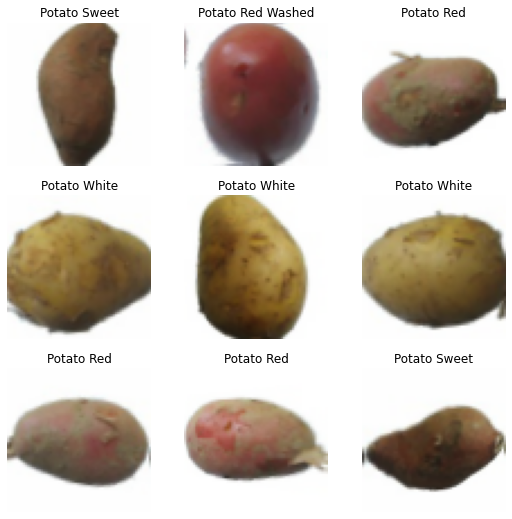

In [8]:
dls.show_batch()

In [9]:
class BasicCNN(Module):
    def __init__(self, n_classes):
        self.conv1      = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2      = nn.Conv2d(32, 64, kernel_size=3)
        self.avgpool    = nn.AdaptiveAvgPool2d(1)
        self.fc         = nn.Linear(64, n_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.avgpool(x)
        x = self.fc(x.view(-1, x.shape[1]))
        return x

In [10]:
model = BasicCNN(n_classes=dls.c)
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy])

In [11]:
learn.summary()

BasicCNN (Input shape: ['64 x 3 x 64 x 64'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 32 x 62 x 62    896        True      
________________________________________________________________
Conv2d               64 x 64 x 29 x 29    18,496     True      
________________________________________________________________
AdaptiveAvgPool2d    64 x 64 x 1 x 1      0          False     
________________________________________________________________
Linear               64 x 4               260        True      
________________________________________________________________

Total params: 19,652
Total trainable params: 19,652
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7f312fbc3f80>
Loss function: CrossEntropyLoss()

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

In [12]:
learn.fit_one_cycle(30, lr_max=3e-3, wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.381699,1.372396,0.283333,00:07
1,1.359659,1.308322,0.602778,00:07
2,1.289580,1.058413,0.736111,00:07
3,1.083094,0.539539,0.841667,00:07
4,0.831989,0.412160,0.741667,00:07
5,0.650186,0.259213,0.983333,00:07
6,0.504028,0.171476,0.975000,00:07
7,0.387947,0.146767,0.944444,00:07
8,0.303557,0.107616,0.975000,00:07
9,0.239003,0.064047,0.986111,00:07


/opt/conda/lib/python3.7/site-packages/fastai2/callback/schedule.py:68: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx = (pos >= pcts).nonzero().max()


Text(0, 0.5, 'loss')

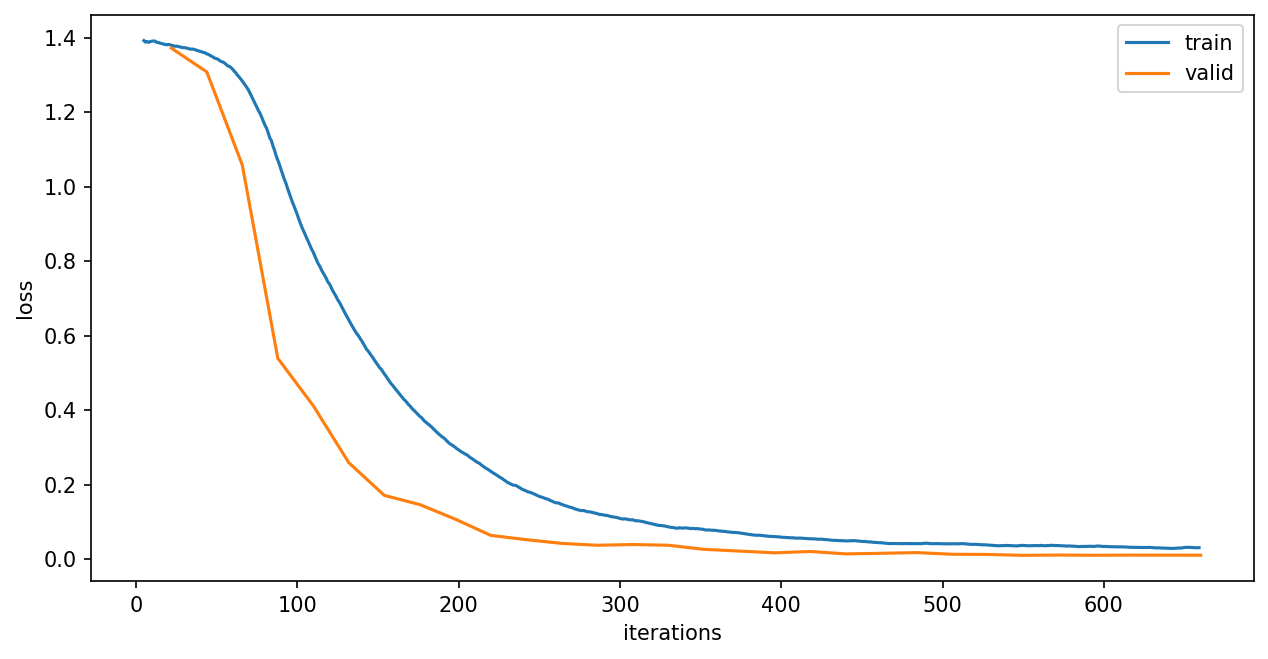

In [13]:
plt.figure(figsize=(10,5), dpi=150)
learn.recorder.plot_loss()
plt.xlabel('iterations')
plt.ylabel('loss')